

## **APPROACH 5**

**THIS FILE CONTAINS VARIOUS DEEP LEARNING MODELS BUILT BY DOWN SAMPLING**

In the previous approach we did not achieve good accuracy because of the imbalance in the dataset.

•	Using the pre-processed EDA file created in FILE1-EDA.

•	We noticed that raw data(pre-processed) was highly imbalanced, due to which we did not find good results on the model built on them.

•	**Down sampling** helped to increase the accuracy to a greater extent about 20% increase in accuracy without overfitting for deep learning models.

**APPROACHES FOLLOWED**

•	Down sampled the GRP_0 which was the majority group to balance the dataset and plotted visualization.

•	Converting Assignment group into unique codes and storing it in a new column called ‘Category’.

•	Splitting the dataset into train and test set

**MODEL BUILDING:**

•	**Model 1**:
Building the model on simple Neural Network, we noticed the model was overfitting.

•	**Model 2:**
  LSTM without pre-trained GloVe embeddings.

**•	Model 3:**
  LSTM with pre-trained GloVe embeddings.

•	Model 4:
  Bi-directional LSTM

**•	Model 5:**
   GRU-biDirectional

**•	Model 6:**
   GRU with pre trained weights

•	Printed the classification report for each of the models , included accuracy and loss plots.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#setting project path
import os
os.chdir('/content/drive/My Drive')

In [0]:
#importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Flatten
from keras.layers import GRU, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
import os
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam

#READING THE DATASET
df=pd.read_csv('eda.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


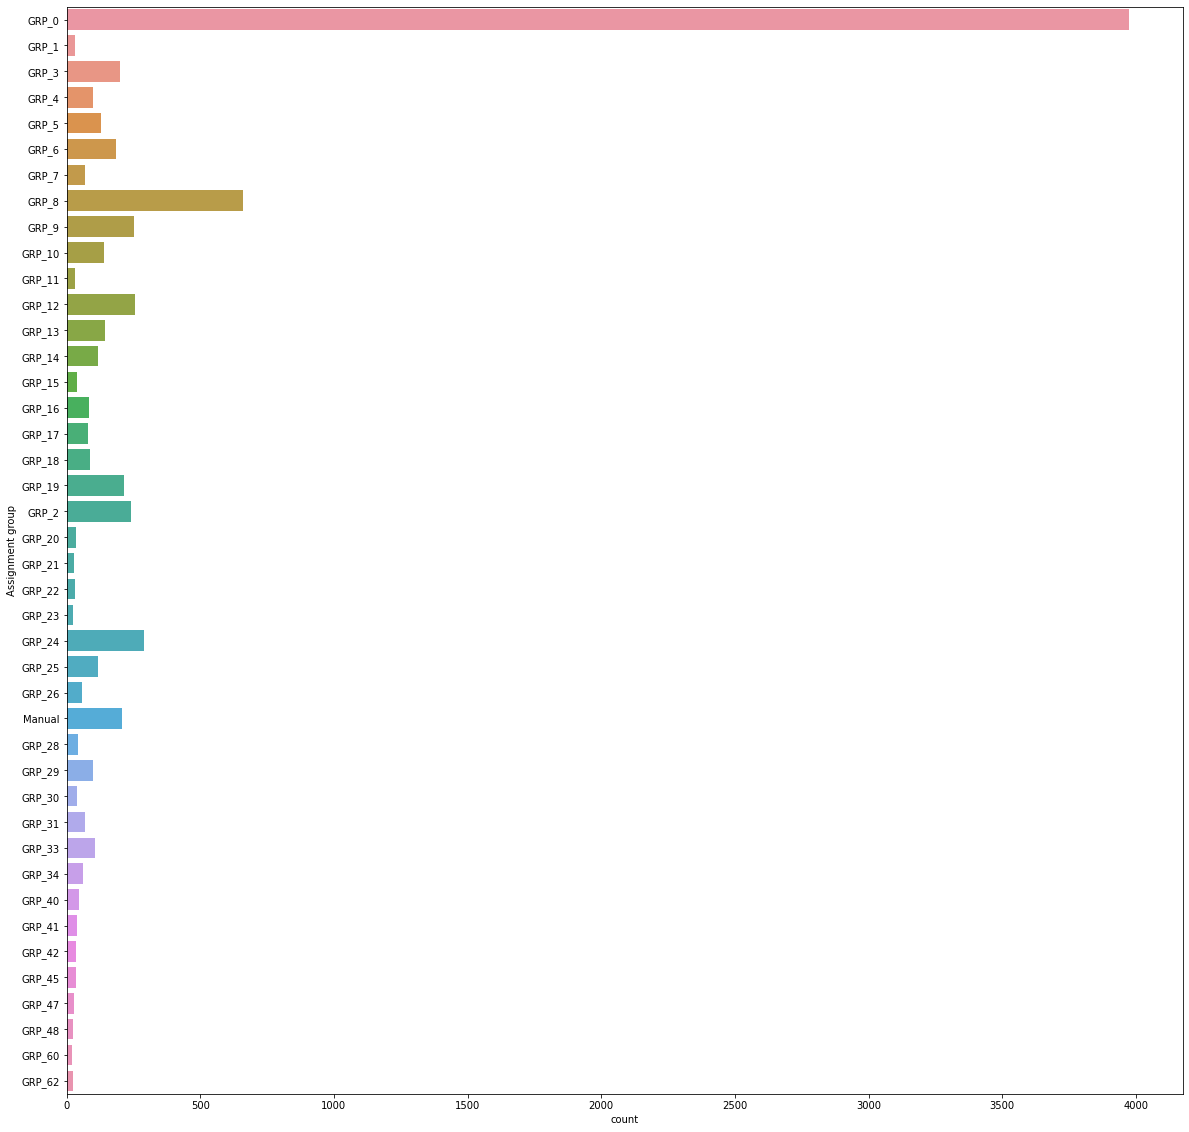

In [0]:
#visualizing the groups
plt.figure(figsize=(20,20))
sns.countplot(y=df['Assignment group'])

#NOTE: the groups are of different sizes hence downsampling them to make them equal

In [0]:
# Downsample majority class i.e GRP_0
from sklearn.utils import resample

df_majority = df.loc[df['Assignment group'] == 'GRP_0']
df_minority = df.loc[df['Assignment group'] != 'GRP_0']
df_majority_downsampled = resample(df_majority, 
                        replace=False,     # sample with replacement
                        n_samples=600,    # to match majority class
                        random_state=42) # reproducible results

In [0]:
#concatinating majority and minority class
df = pd.concat([df_majority_downsampled, df_minority])

In [0]:
max_size = df['Assignment group'].value_counts().max()

lst = [df]
for class_index, group in df.groupby('Assignment group'):
    lst.append(group.sample(max_size-len(group), replace=True))
df = pd.concat(lst)

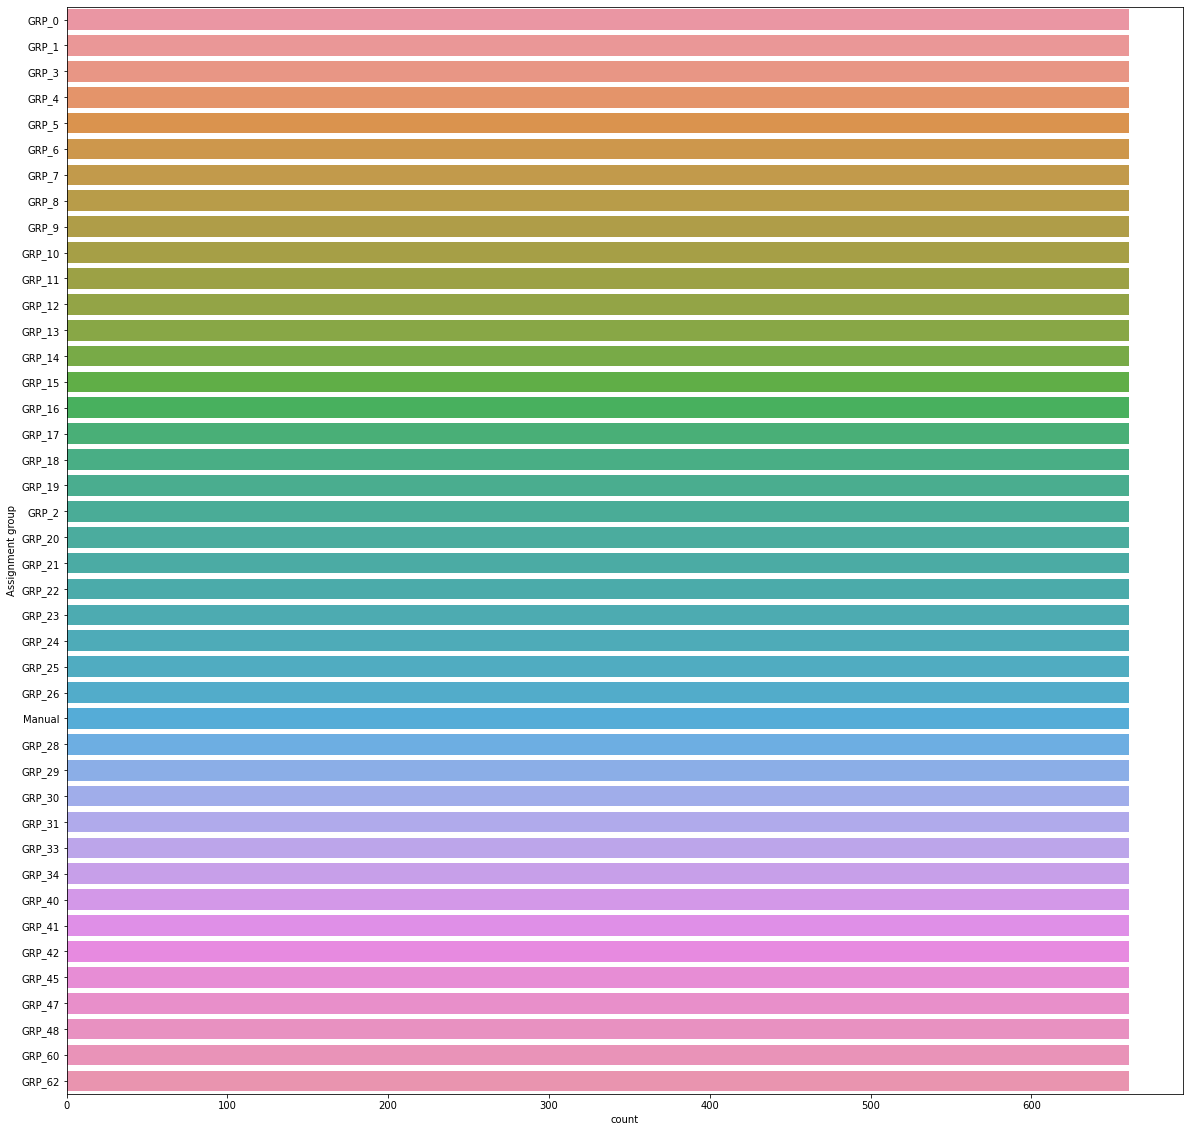

In [0]:
#visulaizing the downsampling
plt.figure(figsize=(20,20))
sns.countplot(y=df['Assignment group'])

all the classes are successfully downsampled.

In [0]:
# Convert categories into unique codes

df['Category'] = df['Assignment group'].astype('category').cat.codes
df.head()

,Unnamed: 0,Description,Assignment group,nndes,mldes,Category
786,786,user variou depart complain slow respons erp e...,GRP_0,user variou depart complain slow respons erp e...,user variou depart complain slow respons erp e...,0
2941,2941,unabl find network drive password reset dxtuls...,GRP_0,unabl find network drive password reset dxtuls...,unabl find network drive password reset dxtuls...,0
1402,1402,unabl open sid password issu sid rtpcnyhq ceqm...,GRP_0,unabl open sid password issu sid rtpcnyhq ceqm...,unabl open sid password issu sid rtpcnyhq ceqm...,0
6707,6707,unabl access net weaver receiv hello unabl acc...,GRP_0,unabl access net weaver receiv hello unabl acc...,unabl access net weaver receiv hello unabl acc...,0
5012,5012,receiv hatryupsfshytd user lock plea reset pas...,GRP_0,receiv hatryupsfshytd user lock plea reset pas...,receiv hatryupsfshytd user lock plea reset pas...,0


In [0]:
#droppoing the assignment groups as we have converted them into unique codes and stored it in 'category'
df = df.drop(['Assignment group'], axis=1)

In [0]:
df['Description'] = df['Description'].astype(str)

In [0]:
df_description = df.Description.values

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
#word tokenizing
from nltk import word_tokenize
df['Description'] = df['Description'].map(lambda x: word_tokenize(x))

In [0]:
# Turn lists back to string
df['Description'] = df['Description'].map(lambda x: ' '.join(x))

In [0]:
# Find length of the words in description to get maxlen

df['Desc_len'] = df['Description'].apply(lambda x: len(x.split(" ")))

In [0]:
df.head()

,Unnamed: 0,Description,nndes,mldes,Category,Desc_len
786,786,user variou depart complain slow respons erp e...,user variou depart complain slow respons erp e...,user variou depart complain slow respons erp e...,0,16
2941,2941,unabl find network drive password reset dxtuls...,unabl find network drive password reset dxtuls...,unabl find network drive password reset dxtuls...,0,8
1402,1402,unabl open sid password issu sid rtpcnyhq ceqm...,unabl open sid password issu sid rtpcnyhq ceqm...,unabl open sid password issu sid rtpcnyhq ceqm...,0,8
6707,6707,unabl access net weaver receiv hello unabl acc...,unabl access net weaver receiv hello unabl acc...,unabl access net weaver receiv hello unabl acc...,0,16
5012,5012,receiv hatryupsfshytd user lock plea reset pas...,receiv hatryupsfshytd user lock plea reset pas...,receiv hatryupsfshytd user lock plea reset pas...,0,29


In [0]:
# Find maxlen 
df['Desc_len'].max()

769

In [0]:
#checking the vocab size 
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

desc = df.Description.str.cat(sep=' ')

tokens = word_tokenize(desc)

vocabulary = set(tokens)
print(len(vocabulary))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
12456


In [0]:
#creating a tokenizer instance and fitting it to the data column (Description)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

    
max_features = 13000  #vocab size is 12456 so i am taking it as 13000
maxlen = 769
embedding_size = 200 #can vary based on the model
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Description'].values)

In [0]:
#defining X and y
X = tokenizer.texts_to_sequences(df['Description'])
X = pad_sequences(X, maxlen = maxlen)
y = pd.get_dummies(df['Category']).values

print('Shape of data:', X.shape)
print('Shape of label:', y.shape)

Shape of data: (27762, 769)
Shape of label: (27762, 42)


In [0]:
y[1]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [0]:
# Splitting into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

## **SIMPLE NEURAL NETWROK MODEL WITHOUT PRE TRAINED WEIGHTS**

 A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria. The concept of neural networks, which has its roots in artificial intelligence, is swiftly gaining popularity in the development of trading systems.
 
 ***ADVANTAGES OF USING NEURAL NETWORK*** 

1. They have the ability to learn and model non-linear and complex relationships. 

2. Parallel processing ability:  Artificial neural networks have numerical strength that can perform more than one job at the same time. 

3. ANNs can generalize — After learning from the initial inputs and their relationships, it can infer unseen relationships on unseen data as well, thus making the model generalize and predict on unseen data.

4. Unlike many other prediction techniques, ANN does not impose any restrictions on the input variables (like how they should be distributed).

5. Gradual corruption:  A network slows over time and undergoes relative degradation. The network problem does not immediately corrode.

***DISADVANTAGES:***

1. Hardware dependence:  Artificial neural networks require processors with parallel processing power, by their structure. For this reason, the realization of the equipment is dependent. 

2. Unexplained functioning of the network: This is the most important problem of ANN. When ANN gives a probing solution, it does not give a clue as to why and how. This reduces trust in the network. 

3. Assurance of proper network structure:  There is no specific rule for determining the structure of artificial neural networks. The appropriate network structure is achieved through experience and trial and error. 

4. The difficulty of showing the problem to the network:  ANNs can work with numerical information. Problems have to be translated into numerical values before being introduced to ANN. The display mechanism to be determined here will directly influence the performance of the network. This depends on the user's ability. 

5. The duration of the network is unknown: The network is reduced to a certain value of the error on the sample means that the training has been completed. This value does not give us optimum results. 

In [0]:
#Model buliding
#Initialize variables

embedding_size=50
batch_size =100
epochs = 20
maxlen=769
model = Sequential() #Sequential model

model.add(Embedding(max_features, embedding_size, input_length=maxlen))  #Init embedding layer with no pretrained wts
#embedding layer takes input of vocabulary size i.e 13000, embedding dimension i.e 50 and input sequence i.e number of columns of dataset i.e 300
model.add(Flatten()) #Use flatten layer
model.add(Dropout(0.5)) #use dropout for regularization
model.add(Dense(10)) #Hidden layer
model.add(Dropout(0.3)) #use dropout for regularization
model.add(Dense(42, activation='sigmoid')) #Output layer+

In [0]:
#To see what our model have, number of layer , output shape ,etc
#model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 769, 50)           650000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 38450)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 38450)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                384510    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 42)                462       
Total params: 1,034,972
Trainable params: 1,034,972
Non-trainable params: 0
____________________________________________

In [0]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
history= model.fit(
  X_train,
  y_train,
  batch_size=batch_size,
  epochs=15,
  validation_data=(X_test,y_test))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20821 samples, validate on 6941 samples
Epoch 1/15
20821/20821 [==============================] - 16s 766us/step - loss: 3.5870 - accuracy: 0.0729 - val_loss: 3.2279 - val_accuracy: 0.1359
Epoch 2/15
20821/20821 [==============================] - 16s 761us/step - loss: 2.8677 - accuracy: 0.1804 - val_loss: 2.1541 - val_accuracy: 0.5760
Epoch 3/15
20821/20821 [==============================] - 16s 759us/step - loss: 2.1732 - accuracy: 0.3658 - val_loss: 1.3553 - val_accuracy: 0.7686
Epoch 4/15
20821/20821 [==============================] - 16s 757us/step - loss: 1.7340 - accuracy: 0.4755 - val_loss: 0.9525 - val_accuracy: 0.8336
Epoch 5/15
20821/20821 [==============================] - 16s 755us/step - loss: 1.4849 - accuracy: 0.5571 - val_loss: 0.7193 - val_accuracy: 0.8604
Epoch 6/15
20821/20821 [==============================] - 16s 756us/step - loss: 1.3165 - accuracy: 0.6135 - val_loss: 0.5796 - val_accuracy: 0.8721
Epoch 7/15
20821/20821 [==============================] -

In [0]:
#Evaluate test set and then print accuracy
test = model.evaluate(X_test, y_test)
print('Test accuracy: ', test[1])

6941/6941 [==============================] - 1s 78us/step
Test accuracy:  0.9230658411979675


In [0]:
#Evaluate train set and then print accuracy
train = model.evaluate(X_train, y_train)
print('Train accuracy: ',train[1])

20821/20821 [==============================] - 2s 77us/step
Train accuracy:  0.9382354617118835


In [0]:
#Store the accuracy results for each model in a dataframe for final comparison
results = pd.DataFrame({'Method':['NN'], 'train acc': train[1], 'test acc':test[1]},index={'1'})
results = results[['Method', 'train acc','test acc']]
results

,Method,train acc,test acc
1,NN,0.938235,0.923066


pritning confusion matric and precision,recall and f1 score

In [0]:

predicted = model.predict(X_test)
predicted


array([[2.6743638e-07, 3.0143690e-06, 2.5194883e-04, ..., 5.9783459e-04,
        1.4504790e-03, 1.0018971e-05],
       [1.6209787e-08, 1.7330841e-14, 3.6131591e-05, ..., 3.6932062e-09,
        1.0383280e-06, 4.4940059e-08],
       [1.3870064e-07, 6.7991904e-11, 6.5724500e-08, ..., 6.6813617e-09,
        8.2677554e-09, 2.6838545e-06],
       ...,
       [2.2481561e-07, 5.8574553e-08, 6.2930712e-07, ..., 5.6886951e-05,
        6.5757320e-07, 1.0754185e-06],
       [9.7500788e-07, 3.8180366e-05, 1.0125400e-05, ..., 4.7141314e-04,
        5.0550050e-05, 3.0333704e-06],
       [5.2515476e-09, 1.3976268e-12, 3.2908445e-09, ..., 5.0067794e-10,
        1.8096348e-10, 4.8295306e-07]], dtype=float32)

In [0]:
predicted = np.argmax(predicted, axis=1)

In [0]:
Y_1 = np.argmax(y_test, axis=1)

In [0]:
#PRINTING THE CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print(classification_report(Y_1, predicted))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       160
           1       0.88      1.00      0.94       169
           2       1.00      0.88      0.93       169
           3       1.00      1.00      1.00       167
           4       0.84      0.88      0.86       161
           5       0.97      0.99      0.98       180
           6       0.96      0.94      0.95       173
           7       0.99      1.00      0.99       156
           8       0.99      1.00      1.00       171
           9       1.00      1.00      1.00       163
          10       0.97      0.97      0.97       177
          11       0.97      0.87      0.92       173
          12       0.97      0.85      0.90       168
          13       1.00      1.00      1.00       169
          14       1.00      1.00      1.00       179
          15       1.00      1.00      1.00       145
          16       1.00      1.00      1.00       160
          17       0.99    

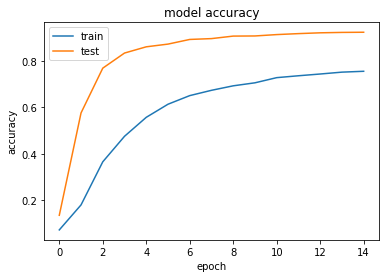

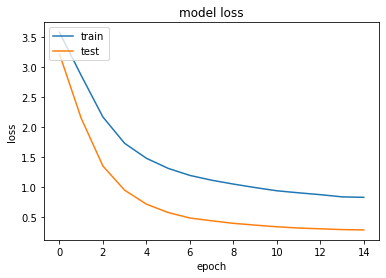

In [0]:
#visulaizing accuracies and loss for train and test set
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The train accuracy seems to not go high after 12th epoch.

In [0]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("nn.h5")

I observed that after 15 epochs there was no improvement in accuracy, hence maintaining the epoch at 15.

 We notice very good accuracies for both train and test data and the model it is slightly  overfitting, so let us try on different models.



### **LSTM WITHOUT PRE TRAINED WEIGHTS**


TO OVERCOME THE CHALLENGE OF UNDERSTANDING THE PREVIOUS OUTPUT WE USE RNNs.

LSTM is a special kind of RNN’s, capable of Learning Long-term dependencies.LSTM’s have a Nature of Remembering information for a long periods of time is their Default behaviour.

***Advantages of Recurrent Neural Network***

The main advantage of RNN over ANN is that RNN can model sequence of data (i.e. time series) so that each sample can be assumed to be dependent on previous ones.

Recurrent neural network are even used with convolutional layers to extend the effective pixel neighborhood.

***Disadvantages of Recurrent Neural Network***

Gradient vanishing and exploding problems.

Training an RNN is a very difficult task.

It cannot process very long sequences if using tanh or relu as an activation function.

In [0]:
#Model buliding

from keras.optimizers import Adam
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D,SpatialDropout1D
model2 = Sequential()
model2.add(Embedding(max_features, 100,  input_length=maxlen))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(42, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 769, 100)          1300000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 769, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 42)                4242      
Total params: 1,384,642
Trainable params: 1,384,642
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
#Define checkpoint, early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min") 

In [0]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
history2 = model2.fit(
  X_train,
  y_train,
  batch_size=100,
  epochs=20,
  validation_data=(X_test,y_test),
  callbacks=[reduce_lr, stop],
  verbose=1
)

Train on 20821 samples, validate on 6941 samples
Epoch 1/20
20821/20821 [==============================] - 453s 22ms/step - loss: 1.0467 - accuracy: 0.7344 - val_loss: 0.6251 - val_accuracy: 0.8441
Epoch 2/20
20821/20821 [==============================] - 453s 22ms/step - loss: 0.5578 - accuracy: 0.8529 - val_loss: 0.4227 - val_accuracy: 0.8803
Epoch 3/20
20821/20821 [==============================] - 460s 22ms/step - loss: 0.3799 - accuracy: 0.8940 - val_loss: 0.3388 - val_accuracy: 0.8980
Epoch 4/20
20821/20821 [==============================] - 462s 22ms/step - loss: 0.3029 - accuracy: 0.9108 - val_loss: 0.3144 - val_accuracy: 0.9088
Epoch 5/20
20821/20821 [==============================] - 452s 22ms/step - loss: 0.2644 - accuracy: 0.9190 - val_loss: 0.2801 - val_accuracy: 0.9179
Epoch 6/20
20821/20821 [==============================] - 453s 22ms/step - loss: 0.2313 - accuracy: 0.9274 - val_loss: 0.2672 - val_accuracy: 0.9170
Epoch 7/20
20821/20821 [==============================] -

We notice slight improvement in accuracy compared to model1(neural network)

In [0]:
#Evaluate test set and then print accuracy
test2 = model2.evaluate(X_test, y_test)
print('Test accuracy: ', test2[1])

6941/6941 [==============================] - 32s 5ms/step
Test accuracy:  0.9262354373931885


In [0]:
#Evaluate train set and then print accuracy
train2 = model2.evaluate(X_train, y_train)
print('Train accuracy: ', train2[1])

20821/20821 [==============================] - 99s 5ms/step
Train accuracy:  0.943326473236084


In [0]:
#for creating classification report
predicted = model2.predict(X_test)
predicted


array([[6.9042967e-06, 1.1877795e-04, 2.1385126e-02, ..., 7.1509317e-02,
        2.5563645e-01, 5.9559505e-04],
       [3.8474950e-06, 1.9352452e-08, 9.9955744e-01, ..., 3.2898356e-06,
        2.4031828e-05, 2.6145031e-05],
       [5.6471821e-05, 1.1638568e-09, 7.9664123e-06, ..., 3.9536467e-06,
        4.2307683e-08, 2.3417357e-05],
       ...,
       [7.9636797e-10, 1.2148538e-03, 8.3439554e-06, ..., 1.5993932e-03,
        6.3988540e-05, 5.0887174e-06],
       [7.8562984e-08, 4.9196457e-04, 1.7036599e-06, ..., 9.3582940e-01,
        1.3894078e-04, 5.2343246e-05],
       [3.4562854e-06, 7.1239192e-10, 5.8097260e-07, ..., 7.4203643e-07,
        2.7122107e-09, 1.9426054e-06]], dtype=float32)

In [0]:
predicted = np.argmax(predicted,axis=1)

In [0]:
Y_2 = np.argmax(y_test, axis=1)

In [0]:

from sklearn.metrics import classification_report
print(classification_report(Y_2, predicted))

              precision    recall  f1-score   support

           0       0.92      0.64      0.76       160
           1       0.99      0.88      0.93       169
           2       1.00      0.89      0.94       169
           3       1.00      1.00      1.00       167
           4       0.97      0.89      0.93       161
           5       0.98      0.96      0.97       180
           6       0.99      0.99      0.99       173
           7       0.99      1.00      0.99       156
           8       0.97      1.00      0.99       171
           9       0.98      1.00      0.99       163
          10       0.97      0.94      0.95       177
          11       0.94      0.94      0.94       173
          12       0.93      0.90      0.92       168
          13       0.94      1.00      0.97       169
          14       1.00      1.00      1.00       179
          15       1.00      1.00      1.00       145
          16       0.98      1.00      0.99       160
          17       1.00    

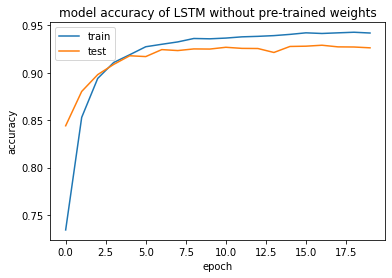

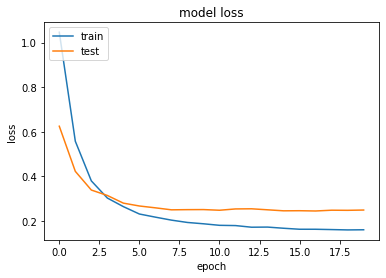

In [0]:
#visulaizing the loss and accuracy
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('model accuracy of LSTM without pre-trained weights')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [0]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model2.to_json()


with open("model2.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model2.save_weights("nn_lstm1.h5")

In [0]:

#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['LSTM'], 'train acc': [train2[1]],'test acc':[test2[1]]},index={'2'})
results= pd.concat([results, tempResultsDf])
results = results[['Method', 'train acc','test acc']]
results

,Method,train acc,test acc
1,NN,0.938235,0.923066
2,LSTM,0.943326,0.926235


We notice an improvement in train and test accuracy.

### **LSTM WITH PRE TRAINED WEIGHTS** - Transfer learning

***GloVe***

GloVe is a word vector technique that rode the wave of word vectors after a brief silence. Just to refresh, word vectors put words to a nice vector space, where similar words cluster together and different words repel.

***Advantages:***

1. The goal of Glove is very straightforward, i.e., to enforce the word vectors to capture sub-linear relationships in the vector space. Thus, it proves to perform better than Word2vec in the word analogoy tasks.

2. Glove adds some more practical meaning into word vectors by considering the relationships between word pair and word pair rather than word and word.

3. Glove gives lower weight for highly frequent word pairs so as to prevent the meaningless stop words like “the”, “an” will not dominate the training progress.

***Disadvantages:***

The model is trained on the co-occurrence matrix of words, which takes a lot of memory for storage. Especially, if you change the hyper-parameters related to the co-occurrence matrix, you have to reconstruct the matrix again, which is very time-consuming.

In [0]:
os.getcwd()

'/content/drive/My Drive'

In [0]:
#loading the pre-trained glove vectors of dimension size 200 from 6B file
from numpy import array
from numpy import asarray
from numpy import zeros
max_features=13000

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/glove.6B.200d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [0]:
#creating a weight matrix
embedding_matrix = zeros((max_features, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
#model building

model3 = Sequential()  #Sequential model
model3.add(Embedding(max_features, 200, input_length=maxlen, weights=[embedding_matrix], trainable=True)) #Init embedding layer with  pretrained wts 
model3.add(Dropout(0.5)) #use dropout for regularization embedding_matrix
model3.add(LSTM(100,return_sequences=True, dropout=0.4))  #Hidden layer with dropout Here return_sequences=true as I want to get output from all layer than apply global max pool over all the output so that I dont miss out important info
model3.add(GlobalMaxPool1D()) #This is to get values from all states and not missing important info
model3.add(Dense(42, activation="sigmoid")) #Final dense layer 
#Note:GlobalMaxPool1D requires output from all lSTMs therfore return_sequences = True, this returns output from all LSTM not just final LSTM 
#ALso GlobalMaxPool1D takes max of all output in very special way this step is done so that every words wether at start or at he end is given importance. 


In [0]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model3.compile(
  loss='categorical_crossentropy',
  #optimizer=Adam(lr=0.01),  #best
  optimizer='adam',
  metrics=['acc']
)

In [0]:
#Define checkpoint, early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min") 

In [0]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
#Here I have used requlaization and model performance tech such as reduced lr, check point and early stop

history3 = model3.fit(
  X_train,
  y_train,
  batch_size=64,
  epochs=25,
  validation_data=(X_test,y_test),
  callbacks=[reduce_lr, stop],
  verbose=1
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20821 samples, validate on 6941 samples
Epoch 1/25
20821/20821 [==============================] - 633s 30ms/step - loss: 3.1594 - acc: 0.2008 - val_loss: 2.4176 - val_acc: 0.3884
Epoch 2/25
20821/20821 [==============================] - 635s 30ms/step - loss: 2.1470 - acc: 0.4338 - val_loss: 1.6595 - val_acc: 0.5695
Epoch 3/25
20821/20821 [==============================] - 634s 30ms/step - loss: 1.5688 - acc: 0.5941 - val_loss: 1.1717 - val_acc: 0.7061
Epoch 4/25
20821/20821 [==============================] - 635s 31ms/step - loss: 1.1465 - acc: 0.7089 - val_loss: 0.8411 - val_acc: 0.7874
Epoch 5/25
20821/20821 [==============================] - 635s 30ms/step - loss: 0.8586 - acc: 0.7816 - val_loss: 0.6424 - val_acc: 0.8307
Epoch 6/25
20821/20821 [==============================] - 636s 31ms/step - loss: 0.6658 - acc: 0.8270 - val_loss: 0.5114 - val_acc: 0.8562
Epoch 7/25
20821/20821 [==============================] - 637s 31ms/step - loss: 0.5381 - acc: 0.8586 - val_loss: 0.4

In [0]:
#Evaluate test set and then print accuracy
test3 = model3.evaluate(X_test, y_test)
print('Test accuracy: ', test3[1])

6941/6941 [==============================] - 39s 6ms/step
Test accuracy:  0.93012535572052


In [0]:
#Evaluate train set and then print accuracy
train3 = model3.evaluate(X_train, y_train)
print('Train accuracy: ', train3[1])

20821/20821 [==============================] - 116s 6ms/step
Train accuracy:  0.9453436732292175


In [0]:
#for creating classification report
predicted = model3.predict(X_test)
predicted


array([[1.1295528e-05, 9.0029836e-04, 4.9921721e-02, ..., 1.2944087e-01,
        4.5016938e-01, 1.1634529e-03],
       [5.5974642e-06, 2.0619244e-09, 4.7927946e-02, ..., 4.6784334e-07,
        1.0283130e-06, 1.7329060e-06],
       [3.8012568e-06, 8.4942643e-11, 6.2703816e-06, ..., 6.7873193e-06,
        8.9396696e-07, 8.4152598e-06],
       ...,
       [2.2043437e-08, 3.3505462e-08, 3.2099756e-08, ..., 7.3789074e-06,
        2.9725399e-07, 1.5420577e-06],
       [4.1442277e-08, 9.7097654e-06, 7.6536871e-06, ..., 3.4524173e-01,
        3.2878554e-05, 3.6447076e-05],
       [1.3157355e-06, 2.0819027e-11, 1.3750982e-06, ..., 3.1092932e-06,
        4.2405375e-07, 7.5327143e-06]], dtype=float32)

In [0]:
predicted = np.argmax(predicted,axis=1)

In [0]:
Y_3 = np.argmax(y_test, axis=1)

In [0]:

from sklearn.metrics import classification_report
print(classification_report(Y_3, predicted))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78       160
           1       0.89      1.00      0.94       169
           2       0.99      0.89      0.93       169
           3       0.99      1.00      1.00       167
           4       0.91      0.92      0.92       161
           5       0.99      0.99      0.99       180
           6       0.99      0.98      0.98       173
           7       0.99      1.00      0.99       156
           8       0.98      1.00      0.99       171
           9       1.00      1.00      1.00       163
          10       0.94      0.94      0.94       177
          11       0.92      0.92      0.92       173
          12       0.91      0.90      0.90       168
          13       0.99      1.00      1.00       169
          14       0.99      1.00      0.99       179
          15       1.00      1.00      1.00       145
          16       1.00      1.00      1.00       160
          17       0.97    

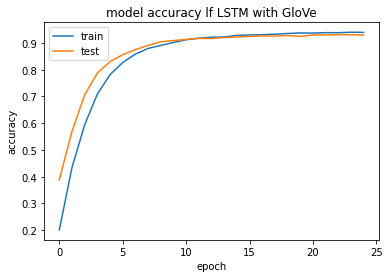

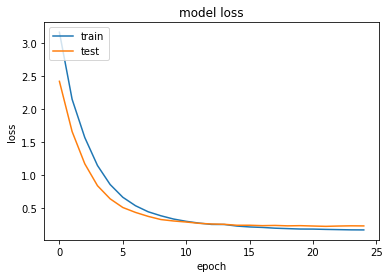

In [0]:
import matplotlib.pyplot as plt

plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])

plt.title('model accuracy lf LSTM with GloVe')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Epochs can be limited to 15 as we see no improvement after 15. however since it takes a lot of time to run, i have left it at 25 epochs as it would consume a large time to re run the same

In [0]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model3.to_json()


with open("model3.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model3.save_weights("nn_lstm_200d.h5")

In [0]:

#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['LSTM with weights'], 'train acc': [train3[1]],'test acc':[test3[1]]},index={'3'})
results= pd.concat([results, tempResultsDf])
results = results[['Method', 'train acc','test acc']]
results

,Method,train acc,test acc
1,NN,0.938235,0.923066
2,LSTM,0.943326,0.926235
3,LSTM with weights,0.945344,0.930125


we notice LSTM with pre trained glove vector works well. it does not overfit and we achieved good accuracy.

Increased accuracy from 92 to 93 on test set and used hyperparameter tuning like lr,patience and experimenting with various layers to be added, this seemed to be the best so far.

## **LSTM with glove embeddings iteration 2- trying with different hidden units **

In [0]:
model7 = Sequential()  #Sequential model
model7.add(Embedding(max_features, 200, input_length=maxlen, weights=[embedding_matrix], trainable=True)) #Init embedding layer with pretrained wts 
model7.add(Dropout(0.5)) #use dropout for regularization embedding_matrix
model7.add(LSTM(128,return_sequences=True, dropout=0.4))  #Hidden layer with dropout Here return_sequences=true as I want to get output from all layer than apply global max pool over all the output so that I dont miss out important info
model7.add(GlobalMaxPool1D()) #This is to get values from all states and not missing important info
model7.add(Dense(42, activation="sigmoid")) #Final dense layer 
#Note:GlobalMaxPool1D requires output from all lSTMs therfore return_sequences = True, this returns output from all LSTM not just final LSTM 
#ALso GlobalMaxPool1D takes max of all output in very special way this step is done so that every words wether at start or at he end is given importance. 
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model7.compile(
  loss='categorical_crossentropy',
  #optimizer=Adam(lr=0.01),  #best
  optimizer='adam',
  metrics=['acc']
)
#Define checkpoint, early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min") 
#Fitting model to xtrain and ytrain with defined epochs and batch size
#Here I have used requlaization and model performance tech such as reduced lr, check point and early stop

history7 = model7.fit(
  X_train,
  y_train,
  batch_size=32,
  epochs=30,
  validation_data=(X_test,y_test),
  callbacks=[reduce_lr, stop],
  verbose=1
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20821 samples, validate on 6941 samples
Epoch 1/30
20821/20821 [==============================] - 1244s 60ms/step - loss: 2.7629 - acc: 0.2755 - val_loss: 1.7569 - val_acc: 0.4988
Epoch 2/30
20821/20821 [==============================] - 1247s 60ms/step - loss: 1.5447 - acc: 0.5627 - val_loss: 1.0554 - val_acc: 0.7143
Epoch 3/30
20821/20821 [==============================] - 1241s 60ms/step - loss: 0.9832 - acc: 0.7302 - val_loss: 0.6941 - val_acc: 0.7927
Epoch 4/30
20821/20821 [==============================] - 1240s 60ms/step - loss: 0.6865 - acc: 0.8097 - val_loss: 0.5226 - val_acc: 0.8499
Epoch 5/30
20821/20821 [==============================] - 1242s 60ms/step - loss: 0.5079 - acc: 0.8581 - val_loss: 0.4007 - val_acc: 0.8793
Epoch 6/30
20821/20821 [==============================] - 1237s 59ms/step - loss: 0.4062 - acc: 0.8834 - val_loss: 0.3365 - val_acc: 0.8973
Epoch 7/30
20821/20821 [==============================] - 1236s 59ms/step - loss: 0.3318 - acc: 0.9028 - val_lo

In [0]:
#Evaluate test set and then print accuracy
test7 = model7.evaluate(X_test, y_test)
print('Test accuracy: ', test7[1])

6941/6941 [==============================] - 83s 12ms/step
Test accuracy:  0.9291168451309204


In [0]:
#Evaluate train set and then print accuracy
train7 = model7.evaluate(X_train, y_train)
print('Train accuracy: ', train7[1])

20821/20821 [==============================] - 255s 12ms/step
Train accuracy:  0.9479371905326843


In [0]:
#for creating classification report
predicted = model7.predict(X_test)
predicted


array([[1.5100971e-08, 5.2091479e-04, 7.3877408e-07, ..., 8.5848570e-04,
        4.4479631e-05, 7.8475805e-06],
       [2.5263492e-07, 8.1779433e-07, 7.2557104e-01, ..., 2.2490483e-05,
        1.5707732e-05, 1.2549758e-04],
       [3.0395311e-05, 1.2806479e-11, 5.5549930e-07, ..., 1.5650880e-07,
        9.1014300e-07, 1.3075080e-05],
       ...,
       [1.0640138e-05, 7.1257353e-04, 3.5023198e-01, ..., 6.8495154e-01,
        9.6103382e-01, 6.5740347e-03],
       [2.9244018e-07, 6.2348576e-05, 4.9556867e-05, ..., 3.0857819e-01,
        2.7193341e-06, 1.4465887e-06],
       [2.1778815e-06, 2.0403155e-11, 1.0043447e-06, ..., 1.5614876e-07,
        4.8742515e-07, 4.1576935e-05]], dtype=float32)

In [0]:
predicted = np.argmax(predicted,axis=1)

In [0]:
Y_7 = np.argmax(y_test, axis=1)

In [0]:

from sklearn.metrics import classification_report
print(classification_report(Y_7, predicted))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       160
           1       0.90      1.00      0.95       169
           2       0.99      0.85      0.92       169
           3       0.99      1.00      0.99       167
           4       0.94      0.92      0.93       161
           5       0.98      0.96      0.97       180
           6       0.99      0.97      0.98       173
           7       1.00      1.00      1.00       156
           8       0.98      1.00      0.99       171
           9       0.99      1.00      1.00       163
          10       0.99      0.96      0.97       177
          11       0.92      0.93      0.93       173
          12       0.94      0.93      0.94       168
          13       0.99      1.00      1.00       169
          14       1.00      1.00      1.00       179
          15       1.00      1.00      1.00       145
          16       0.99      1.00      0.99       160
          17       0.98    

In [0]:

#Store the accuracy results for each model in a dataframe for final comparison
results1 = pd.DataFrame({'Method':['LSTM_128 with weights'], 'train acc': train7[1], 'test acc':test7[1]},index={'7'})
results1 = results1[['Method', 'train acc','test acc']]
results1

,Method,train acc,test acc
7,LSTM_128 with weights,0.947937,0.929117


WE DONT NOTICE ANY IMPROVEMENT , INFACT THE MODEL IS NOT PERFORMING WELL SO WE WILL CONSIDER LSTM WITH 100 HIDDEN UNITS ONLY

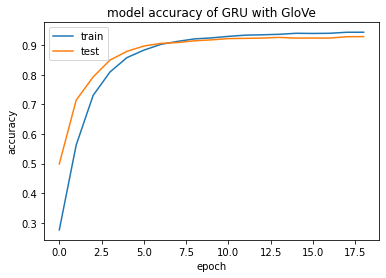

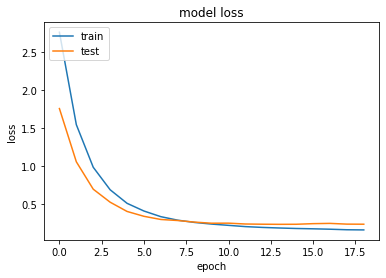

In [0]:
import matplotlib.pyplot as plt

plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])

plt.title('model accuracy of GRU with GloVe')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#TITLE TO BE LSTM WITH GLOVE ERROR WHILE NAMING. FILE TAKES 8 HOURS APPROXIMATELY TO RUN.

In [0]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model7.to_json()


with open("model7.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model7.save_weights("nn_LSTM128_200d.h5")

# **USING BI-DIRECTIONAL LSTM**

**Why BiLSTM?**

Bi-LSTM is the possibility for Bi-LSTM to leverage future context chunks to learn better representations of single words. There is no special training step or units added, the idea is just to read a sentence forward and backward to capture more information.

A bidirectional LSTM (BiLSTM) layer learns bidirectional long-term dependencies between time steps of time series or sequence data. These dependencies can be useful when you want the network to learn from the complete time series at each time step.

In [0]:
#Model buliding
model4 = Sequential()  #Sequential model
model4.add(Embedding(max_features, 200, input_length = maxlen, weights = [embedding_matrix]))
#embedding layer takes input of vocabulary size, embedding dimension i.e 200 and input sequence i.e number of columns of dataset
#Here I am using pretrained glove vector stored in variable 
model4.add(Dropout(0.5)) #use dropout for regularization embedding_matrix
model4.add(Bidirectional(LSTM(100, dropout=0.5)))  #Hidden layer with dropout Here return_sequences=true as I want to get output from all layer than apply global max pool over all the output so that I dont miss out important info
model4.add(Dense(42, activation="sigmoid")) #Final dense layer 

In [0]:
#print model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 769, 200)          2600000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 769, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 42)                8442      
Total params: 2,849,242
Trainable params: 2,849,242
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Compile model with optimizer adam, loss as categorical cross entropy and metric is accuracy
model4.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [0]:
#Define checkpoint, early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min") 

In [0]:
#Fitting model to X and y with defined epochs and batch size
#Here I have used requlaization and model performance tech such as reduced lr and early stop

history4 = model4.fit(
  X_train,
  y_train,
  batch_size=64,
  epochs=20,
  validation_split = 0.2,
  callbacks=[reduce_lr, stop],
  verbose=1
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16656 samples, validate on 4165 samples
Epoch 1/20
16656/16656 [==============================] - 949s 57ms/step - loss: 3.1093 - acc: 0.1651 - val_loss: 2.2671 - val_acc: 0.3767
Epoch 2/20
16656/16656 [==============================] - 937s 56ms/step - loss: 2.0234 - acc: 0.4295 - val_loss: 1.4127 - val_acc: 0.6031
Epoch 3/20
16656/16656 [==============================] - 955s 57ms/step - loss: 1.3460 - acc: 0.6327 - val_loss: 0.9124 - val_acc: 0.7556
Epoch 4/20
16656/16656 [==============================] - 945s 57ms/step - loss: 0.8992 - acc: 0.7565 - val_loss: 0.6414 - val_acc: 0.8238
Epoch 5/20
16656/16656 [==============================] - 938s 56ms/step - loss: 0.6464 - acc: 0.8222 - val_loss: 0.4995 - val_acc: 0.8564
Epoch 6/20
16656/16656 [==============================] - 941s 57ms/step - loss: 0.5135 - acc: 0.8533 - val_loss: 0.4224 - val_acc: 0.8768
Epoch 7/20
16656/16656 [==============================] - 945s 57ms/step - loss: 0.4288 - acc: 0.8732 - val_loss: 0.3

In [0]:
#Evaluate test set and then print accuracy
test4 = model4.evaluate(X_test, y_test)
print('Test accuracy: ', test4[1])

6941/6941 [==============================] - 75s 11ms/step
Test accuracy:  0.9157181978225708


In [0]:
#Evaluate train set and then print accuracy
train4 = model4.evaluate(X_train, y_train)
print('Train accuracy: ', train4[1])

20821/20821 [==============================] - 224s 11ms/step
Train accuracy:  0.9372268319129944


In [0]:
#for creating classification report
predicted = model4.predict(X_test)
predicted


array([[2.41522820e-08, 9.82105732e-04, 8.06529715e-05, ...,
        5.02616167e-04, 5.15341759e-04, 4.38522657e-05],
       [1.01482627e-07, 3.99700781e-07, 4.47175771e-01, ...,
        1.20578788e-05, 4.63873148e-04, 6.92183094e-05],
       [3.25441360e-04, 1.61192659e-08, 9.84496291e-05, ...,
        2.99915996e-06, 1.34268766e-05, 1.40531947e-05],
       ...,
       [6.47638174e-08, 5.48495848e-07, 5.65409660e-04, ...,
        1.08474493e-03, 2.11295485e-03, 1.06402285e-05],
       [1.18133187e-07, 1.45226717e-04, 7.89065380e-05, ...,
        1.23572260e-01, 2.64465809e-04, 1.08296099e-05],
       [3.11553478e-04, 1.37915368e-08, 8.05896125e-05, ...,
        1.56587566e-06, 7.73349348e-06, 3.08047929e-05]], dtype=float32)

In [0]:
predicted = np.argmax(predicted,axis=1)

In [0]:
Y_4 = np.argmax(y_test, axis=1)

In [0]:

from sklearn.metrics import classification_report
print(classification_report(Y_4, predicted))

              precision    recall  f1-score   support

           0       0.83      0.61      0.71       160
           1       0.90      1.00      0.95       169
           2       0.98      0.86      0.91       169
           3       1.00      1.00      1.00       167
           4       0.87      0.94      0.90       161
           5       0.98      0.92      0.95       180
           6       0.98      0.97      0.97       173
           7       0.98      1.00      0.99       156
           8       0.97      1.00      0.98       171
           9       1.00      1.00      1.00       163
          10       0.98      0.96      0.97       177
          11       0.90      0.89      0.90       173
          12       0.90      0.82      0.86       168
          13       0.99      1.00      0.99       169
          14       0.99      1.00      1.00       179
          15       0.99      1.00      0.99       145
          16       0.99      1.00      1.00       160
          17       0.98    

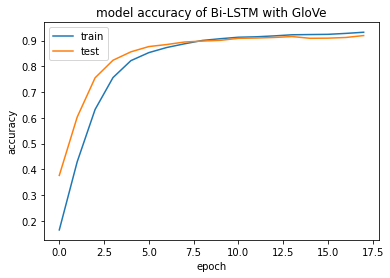

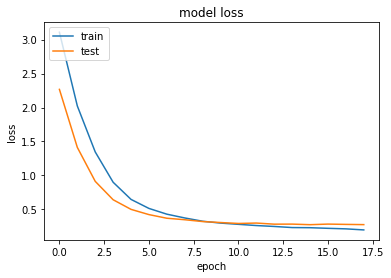

In [0]:
import matplotlib.pyplot as plt

plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])

plt.title('model accuracy of Bi-LSTM with GloVe')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [0]:

#Store the accuracy results for each model in a dataframe for final comparison
results1 = pd.DataFrame({'Method':['Bi-LSTM with weights'], 'train acc': train4[1], 'test acc':test4[1]},index={'1'})
results1 = results1[['Method', 'train acc','test acc']]
results1

,Method,train acc,test acc
1,Bi-LSTM with weights,0.937227,0.915718


In [0]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model4.to_json()


with open("model4.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model4.save_weights("nn_bi-lstm_200d.h5")

## **Bi-directional lstm iteration 2**

In [0]:
#CHECKING WITH BATCH SIZE OF 32 AND ADDING A GLOBALMAXPOOOLNG LAYER 
#Model buliding
model_bi = Sequential()  #Sequential model
model_bi.add(Embedding(max_features, 200, input_length = maxlen, weights = [embedding_matrix]))
#embedding layer takes input of vocabulary size, embedding dimension i.e 200 and input sequence i.e number of columns of dataset 
#Here I am using pretrained glove vector stored in variable 
model_bi.add(Dropout(0.5)) #use dropout for regularization embedding_matrix
model_bi.add(Bidirectional(LSTM(100,return_sequences=True, dropout=0.4)))  #Hidden layer with dropout Here return_sequences=true as I want to get output from all layer than apply global max pool over all the output so that I dont miss out important info
model_bi.add(GlobalMaxPool1D())
model_bi.add(Dense(42, activation="sigmoid")) #Final dense layer 

In [0]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model_bi.compile(
  loss='categorical_crossentropy',
  #optimizer=Adam(lr=0.01),  #best
  optimizer='adam',
  metrics=['acc']
)

In [0]:
#Define checkpoint, early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min") 

In [0]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
#Here I have used requlaization and model performance tech such as reduced lr, check point and early stop

history_bi = model_bi.fit(
  X_train,
  y_train,
  batch_size=32,
  epochs=25,
  validation_data=(X_test,y_test),
  callbacks=[reduce_lr, stop],
  verbose=1
)

Train on 20821 samples, validate on 6941 samples
Epoch 1/25
20821/20821 [==============================] - 1633s 78ms/step - loss: 2.4976 - acc: 0.3479 - val_loss: 1.4333 - val_acc: 0.6039
Epoch 2/25
20821/20821 [==============================] - 1640s 79ms/step - loss: 1.1587 - acc: 0.6943 - val_loss: 0.7185 - val_acc: 0.8006
Epoch 3/25
20821/20821 [==============================] - 1651s 79ms/step - loss: 0.6771 - acc: 0.8196 - val_loss: 0.4904 - val_acc: 0.8617
Epoch 4/25
20821/20821 [==============================] - 1636s 79ms/step - loss: 0.4713 - acc: 0.8687 - val_loss: 0.4030 - val_acc: 0.8698
Epoch 5/25
20821/20821 [==============================] - 1630s 78ms/step - loss: 0.3815 - acc: 0.8897 - val_loss: 0.3276 - val_acc: 0.8987
Epoch 6/25
20821/20821 [==============================] - 1647s 79ms/step - loss: 0.3107 - acc: 0.9062 - val_loss: 0.3012 - val_acc: 0.9032
Epoch 7/25
20821/20821 [==============================] - 1667s 80ms/step - loss: 0.2690 - acc: 0.9167 - val_lo

In [0]:
#Evaluate test set and then print accuracy
test_bi = model_bi.evaluate(X_test, y_test)
print('Test accuracy: ', test_bi[1])

6941/6941 [==============================] - 83s 12ms/step
Test accuracy:  0.9302694201469421


In [0]:
#Evaluate train set and then print accuracy
train_bi = model_bi.evaluate(X_train, y_train)
print('Train accuracy: ', train_bi[1])

20821/20821 [==============================] - 246s 12ms/step
Train accuracy:  0.9488016963005066


In [0]:
#for creating classification report
predicted = model_bi.predict(X_test)
predicted


array([[8.1295303e-07, 3.2384567e-05, 9.0515107e-09, ..., 2.1997094e-04,
        1.2880564e-04, 8.1079827e-07],
       [8.9042182e-08, 2.4926240e-11, 8.6158514e-04, ..., 5.6446186e-09,
        1.3534830e-07, 2.6588078e-09],
       [8.8204411e-07, 6.6476061e-11, 2.2520231e-05, ..., 2.7883900e-09,
        7.0284334e-09, 4.7156195e-06],
       ...,
       [6.7454491e-09, 1.5631318e-03, 7.5240376e-07, ..., 1.6842991e-02,
        4.7496571e-05, 1.6617775e-04],
       [8.3907373e-08, 2.6603639e-03, 4.0730834e-04, ..., 7.1831560e-01,
        6.2526287e-06, 9.1519476e-05],
       [2.7588338e-05, 1.8271801e-11, 2.5625875e-05, ..., 6.9341062e-09,
        1.1659932e-09, 1.5120117e-04]], dtype=float32)

In [0]:
predicted = np.argmax(predicted,axis=1)

In [0]:
Y_bi = np.argmax(y_test, axis=1)

In [0]:

from sklearn.metrics import classification_report
print(classification_report(Y_bi, predicted))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81       160
           1       0.90      1.00      0.95       169
           2       0.97      0.84      0.90       169
           3       1.00      1.00      1.00       167
           4       0.94      0.92      0.93       161
           5       0.94      0.98      0.96       180
           6       0.98      0.99      0.99       173
           7       1.00      1.00      1.00       156
           8       0.99      1.00      1.00       171
           9       1.00      1.00      1.00       163
          10       0.97      0.97      0.97       177
          11       0.94      0.95      0.95       173
          12       0.93      0.89      0.91       168
          13       1.00      1.00      1.00       169
          14       0.99      1.00      1.00       179
          15       0.99      1.00      1.00       145
          16       0.99      1.00      1.00       160
          17       0.99    

In [0]:

#Store the accuracy results for each model in a dataframe for final comparison
results1 = pd.DataFrame({'Method':['LSTM_iter2_with weights'], 'train acc': train_bi[1], 'test acc':test_bi[1]},index={'7'})
results1 = results1[['Method', 'train acc','test acc']]
results1

,Method,train acc,test acc
7,LSTM_iter2_with weights,0.948802,0.930269


### **GRU** - BiDirectional without pretrained embeddings

**Gated Recurrent Unit** - To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

**Why GRU over LSTM?**
The GRU controls the flow of information like the LSTM unit, but without having to use a memory unit. It just exposes the full hidden content without any control.

GRU is relatively new, and from my perspective, the performance is on par with LSTM, but computationally more efficient.

ADVANTAGES:
1. From my experience, GRUs train faster and perform better than LSTMs on less training data if you are doing language modeling (not sure about other tasks).

2. GRUs are simpler and thus easier to modify, for example adding new gates in case of additional input to the network. It's just less code in general.

3. LSTMs should in theory remember longer sequences than GRUs and outperform them in tasks requiring modeling long-distance relations.

In [0]:
#USING GRU MODEL WITH RMSPROP AS OPTIMIZER
model5 = Sequential()
model5.add(Embedding(max_features, 200,input_length=maxlen))
model5.add(Bidirectional(GRU(128, return_sequences = True)))
model5.add(GlobalMaxPool1D())
model5.add(Dropout(0.2))
model5.add(Dense(42, activation="softmax"))
model5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 769, 200)          2600000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 769, 256)          252672    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 42)                10794     
Total params: 2,863,466
Trainable params: 2,863,466
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping
history = model5.fit(X_train,y_train,batch_size=100,epochs=15,validation_split=0.2)
                     

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16656 samples, validate on 4165 samples
Epoch 1/15
16656/16656 [==============================] - 819s 49ms/step - loss: 2.7854 - accuracy: 0.3421 - val_loss: 1.7152 - val_accuracy: 0.6139
Epoch 2/15
16656/16656 [==============================] - 815s 49ms/step - loss: 1.1605 - accuracy: 0.7147 - val_loss: 0.8000 - val_accuracy: 0.7899
Epoch 3/15
16656/16656 [==============================] - 813s 49ms/step - loss: 0.5626 - accuracy: 0.8482 - val_loss: 0.5061 - val_accuracy: 0.8519
Epoch 4/15
16656/16656 [==============================] - 832s 50ms/step - loss: 0.3721 - accuracy: 0.8922 - val_loss: 0.4037 - val_accuracy: 0.8852
Epoch 5/15
16656/16656 [==============================] - 817s 49ms/step - loss: 0.2852 - accuracy: 0.9134 - val_loss: 0.3720 - val_accuracy: 0.8929
Epoch 6/15
16656/16656 [==============================] - 821s 49ms/step - loss: 0.2416 - accuracy: 0.9243 - val_loss: 0.3587 - val_accuracy: 0.8994
Epoch 7/15
16656/16656 [==============================] -

In [0]:
#Evaluate test set and then print accuracy
results5 = model5.evaluate(X_test, y_test)
print('Test accuracy: ', results5[1])

6941/6941 [==============================] - 70s 10ms/step
Test accuracy:  0.9194640517234802


In [0]:
#Evaluate train set and then print accuracy
results5 = model5.evaluate(X_train, y_train)
print('Train accuracy: ', results5[1])

20821/20821 [==============================] - 210s 10ms/step
Train accuracy:  0.9389078617095947


In [0]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model5.to_json()


with open("model5.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model5.save_weights("nn_gru.h5")

In [0]:
#for creating classification report
predicted = model5.predict(X_test)
predicted


array([[1.0138890e-10, 2.8903983e-06, 1.2080925e-06, ..., 3.9012026e-04,
        8.1038525e-05, 4.3951943e-07],
       [3.3977683e-04, 3.9951567e-07, 9.9198735e-01, ..., 6.0259635e-03,
        4.9104379e-04, 5.6997010e-06],
       [3.0027778e-08, 9.8153430e-10, 1.9784170e-09, ..., 3.9349292e-08,
        4.6617966e-08, 3.4534776e-06],
       ...,
       [7.5505768e-11, 6.3069878e-05, 8.5421343e-06, ..., 2.9690602e-04,
        1.4697907e-05, 2.7329461e-05],
       [9.6249951e-06, 1.0723076e-04, 2.4344099e-03, ..., 9.2533606e-01,
        2.6290072e-04, 9.1114762e-04],
       [3.6836356e-09, 4.8038209e-11, 2.9775721e-10, ..., 1.0867627e-08,
        2.6894234e-09, 2.1841247e-07]], dtype=float32)

In [0]:
predicted = np.argmax(predicted,axis=1)

In [0]:
Y_5 = np.argmax(y_test, axis=1)

In [0]:

from sklearn.metrics import classification_report
print(classification_report(Y_5, predicted))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72       160
           1       0.92      1.00      0.96       169
           2       0.98      0.87      0.92       169
           3       1.00      1.00      1.00       167
           4       0.94      0.83      0.88       161
           5       0.99      0.95      0.97       180
           6       0.99      0.95      0.97       173
           7       1.00      1.00      1.00       156
           8       0.99      1.00      0.99       171
           9       1.00      0.98      0.99       163
          10       0.98      0.97      0.97       177
          11       0.88      0.84      0.86       173
          12       0.89      0.89      0.89       168
          13       0.99      1.00      0.99       169
          14       0.99      1.00      1.00       179
          15       1.00      1.00      1.00       145
          16       1.00      1.00      1.00       160
          17       0.98    

### **GRU WITH PRE-TRAINED WEIGHTS**

In [0]:
#model building

model6 = Sequential()  #Sequential model
model6.add(Embedding(max_features, 200, input_length=maxlen, weights=[embedding_matrix], trainable=True)) #Init embedding layer with  pretrained wts 
model6.add(Dropout(0.5)) #use dropout for regularization embedding_matrix
model6.add(GRU(100,return_sequences=True, dropout=0.4))  #Hidden layer with dropout Here return_sequences=true as I want to get output from all layer than apply global max pool over all the output so that I dont miss out important info
model6.add(GlobalMaxPool1D()) #This is to get values from all states and not missing important info
model6.add(Dense(42, activation="sigmoid")) #Final dense layer 
#Note:GlobalMaxPool1D requires output from all lSTMs therfore return_sequences = True, this returns output from all LSTM not just final LSTM 
#ALso GlobalMaxPool1D takes max of all output in very special way this step is done so that every words wether at start or at he end is given importance. 


In [0]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy

model6.compile(
  loss='categorical_crossentropy',
  #optimizer=Adam(lr=0.01),  #best
  optimizer='adam',
  metrics=['acc']
)

In [0]:
#Define checkpoint, early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min") 

In [0]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
#Here I have used requlaization and model performance tech such as reduced lr, check point and early stop

history6 = model6.fit(
  X_train,
  y_train,
  batch_size=100,
  epochs=25,
  validation_data=(X_test,y_test),
  callbacks=[reduce_lr, stop],
  verbose=1
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20821 samples, validate on 6941 samples
Epoch 1/25
20821/20821 [==============================] - 608s 29ms/step - loss: 3.4013 - acc: 0.1534 - val_loss: 2.8763 - val_acc: 0.2989
Epoch 2/25
20821/20821 [==============================] - 619s 30ms/step - loss: 2.4728 - acc: 0.3650 - val_loss: 1.9701 - val_acc: 0.4936
Epoch 3/25
20821/20821 [==============================] - 622s 30ms/step - loss: 1.7991 - acc: 0.5182 - val_loss: 1.4057 - val_acc: 0.6335
Epoch 4/25
20821/20821 [==============================] - 629s 30ms/step - loss: 1.3324 - acc: 0.6579 - val_loss: 1.0044 - val_acc: 0.7521
Epoch 5/25
20821/20821 [==============================] - 638s 31ms/step - loss: 0.9836 - acc: 0.7500 - val_loss: 0.7691 - val_acc: 0.8035
Epoch 6/25
20821/20821 [==============================] - 634s 30ms/step - loss: 0.7515 - acc: 0.8041 - val_loss: 0.5933 - val_acc: 0.8519
Epoch 7/25
20821/20821 [==============================] - 639s 31ms/step - loss: 0.5963 - acc: 0.8473 - val_loss: 0.4

In [0]:
#Evaluate test set and then print accuracy
test6 = model6.evaluate(X_test, y_test)
print('Test accuracy: ', test6[1])

6941/6941 [==============================] - 41s 6ms/step
Test accuracy:  0.9335830807685852


In [0]:
#Evaluate train set and then print accuracy
train6 = model6.evaluate(X_train, y_train)
print('Train accuracy: ', train6[1])

20821/20821 [==============================] - 122s 6ms/step
Train accuracy:  0.9480812549591064


In [0]:

#Store the accuracy results for each model in a dataframe for final comparison
results1 = pd.DataFrame({'Method':['GRU with weights'], 'train acc': train6[1], 'test acc':test6[1]},index={'6'})
results1 = results1[['Method', 'train acc','test acc']]
results1

,Method,train acc,test acc
6,GRU with weights,0.948081,0.933583


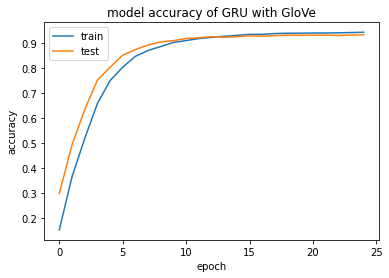

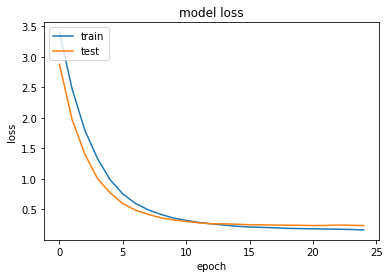

In [0]:
import matplotlib.pyplot as plt

plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])

plt.title('model accuracy of GRU with GloVe')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [0]:
#for creating classification report
predicted = model6.predict(X_test)
predicted


array([[4.91633543e-08, 4.01407480e-04, 6.32040155e-07, ...,
        1.36476755e-03, 6.67221248e-05, 8.44367314e-05],
       [2.14063289e-06, 1.94150118e-08, 7.99223661e-01, ...,
        1.50704227e-05, 3.77921679e-05, 6.89259032e-05],
       [1.42973895e-05, 5.82610893e-09, 1.00889802e-03, ...,
        3.35953428e-06, 2.29552377e-08, 5.88803814e-05],
       ...,
       [4.09248671e-08, 9.51361528e-07, 1.46538994e-07, ...,
        1.94936991e-04, 5.90886771e-07, 3.75559875e-06],
       [2.23404584e-07, 4.44740057e-04, 1.57874638e-05, ...,
        3.32469165e-01, 4.94773412e-05, 1.46625953e-05],
       [1.47231422e-05, 8.86068996e-09, 2.11268663e-04, ...,
        5.81190579e-06, 1.58079132e-08, 1.34832735e-04]], dtype=float32)

In [0]:
predicted = np.argmax(predicted,axis=1)

In [0]:
Y_6 = np.argmax(y_test, axis=1)

In [0]:

from sklearn.metrics import classification_report
print(classification_report(Y_6, predicted))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       160
           1       0.96      1.00      0.98       169
           2       1.00      0.85      0.92       169
           3       1.00      1.00      1.00       167
           4       0.92      0.89      0.91       161
           5       0.98      0.94      0.96       180
           6       0.99      0.98      0.99       173
           7       0.99      1.00      1.00       156
           8       0.98      1.00      0.99       171
           9       0.99      1.00      1.00       163
          10       0.97      0.95      0.96       177
          11       0.96      0.92      0.94       173
          12       0.95      0.92      0.93       168
          13       1.00      1.00      1.00       169
          14       0.98      1.00      0.99       179
          15       0.99      1.00      1.00       145
          16       0.99      1.00      1.00       160
          17       1.00    

In [0]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model6.to_json()


with open("model6.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model6.save_weights("nn_GRU_200d.h5")

### **FINAL COMPARISON**


<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>


<table>
  <tr>
    <th>MODEL</th>
    <th>TRAIN ACCURACY</th>
    <th>TEST ACCURACY</th>
  </tr>
  <tr>
    <td>NN</td>
    <td>0.938235</td>
    <td>0.923066</td>
  </tr>
  <tr>
    <td>LSTM</td>
    <td> 0.943326</td>
    <td> 0.926235</td>
  </tr>
  <tr>
    <td>LSTM with pre weights</td>
    <td> 0.945344</td>
    <td> 0.930125</td>
  </tr>
  <tr>
    <td>	Bi-LSTM with weights</td>
    <td>	0.937227</td>
    <td>	0.915718</td>
  </tr>
    <tr>
    <td>Bi-LSTM iter 2 </td>
    <td>0.9488</td>
    <td>0.9302</td>
  </tr>
  <tr>
    <td>Bi-GRU </td>
    <td>0.93890</td>
    <td>0.91946</td>
  </tr>
  <tr>
    <td>GRU with pre weights</td>
    <td>0.948081</td>
    <td>	0.933583</td>
  </tr>
</table>

</body>
</html>


WE NOTICE FROM THE ABOVE TABLE THAT LSTM WITH PRE-TRAINED WEIGHTS HAVE PERFOMED REALLY WELL IN BOTH TEST AND TRAIN DATA WITHOUT OVERFITTING AND HAS GOOD PRECISION SCORES WHEN COMPARED TO GRU MODEL WHICH HAS HIGH ACCURACY ABOUT 0.2% MORE BUT THE PRECISION IS LOW . Bi-DIRECTIONAL LSTM HAS ALSO PERFORMED EQUALLY GOOD.

## **LIMITATIONS**

The dataset is highly imbalanced considering our target variable which could affect the performance measurement criteria of our classification model.

Noticed that the caller feature has no added importance.

Even though, the submitted model has high accuracy, it is taking too much time to run. The model can be upgraded to run faster, almost in real-time or near real-time.

## ***CONCLUSION:***
 
**LSTM  with pre-trained weights** performed the best with a train accuracy of 94.5344% and test accuracy of 93.0125 with good precision scores.

**Bi-Directional LSTM iteration 2** has also performed really well with good precision scores and an accuracy of about 94.88% on train and 93.02 on test.

 GRU  WITH WEIGHTS has also performed well but their precision score is low.

Solving this project has helped to strengthen and better understanding of our knowledge in Natural Language Processing.
Since this is a real-world problem it was very tuff to proceed with it initially, however as time progressed we got a hold of it but still struggled to get good accuracy of the model.

Helped us to learn the most basic and mandatory steps to be followed in pre processing which helped us learn a lot of techniques.

